In [1]:
#importing
%matplotlib inline
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.linalg as sl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline
from IPython.core.display import HTML
sns.set() #Making seaborn the default styling 

In [2]:
########################
# Helper Functions
########################

def simple_linear_reg(x,y):
    #creating OLS regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    def linefitline(b):
        return intercept + slope * b
    line1 = linefitline(x)

    r2 = r2_score(y, linefitline(x))
    #print('The rsquared value is: ' + str(r2))

    #plot line
    plt.scatter(x,y)
    plt.plot(x,line1, c = 'g')
    plt.show()
    
    return r2

class multiple_linear_reg_model(object):
    '''Class used to bundle together the data, coefficients, parameters, and statistics 
    of the simple linear regression model '''
    
    def __init__(self,X,y):
        '''Initializing the dataset and the basic computed values:
        x,y : datasets
        n: number of observations 
        x_bar, y_bar: means of variables
        s_xx, s_yy, s_xy: short hand notation, e.g. s_xx = sum(x - x_bar)^2 
        '''
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.P = X.shape[1] -1
        self.X_bar = np.mean(self.X,0)
        self.y_bar = np.mean(self.y)
        self.XX = self.X.T @ self.X
    
        #Attributes defined here but initialized in the other methods
        self.b, self.H, self.M = None, None, None
        self.e = None
        self.y_hat, self.R2, self.R2_a = None, None, None
        self.SS_tot, self.SS_res, self.SS_exp = None, None, None
        self.S2_n_p_1, self.S2_b, self.S_b  = None, None, None
        self.b_t_values, self.b_t_p_values, self.F_value, self.F_p_value = None, None, None, None
    
    
    def fit(self):
        self.b = np.linalg.inv(self.XX) @ self.X.T @ self.y
        self.H = self.X @ np.linalg.inv(self.XX) @ self.X.T
        self.M = np.identity(self.n) - self.H
        
        #Predicted values and residuals
        self.y_hat = self.X @ self.b
        self.e = self.y - self.y_hat
        
        #Sum of squares
        self.SS_tot = np.sum( (self.y - self.y_bar)**2 )
        self.SS_res = np.sum( (self.y - self.y_hat)**2 )
        self.SS_exp = np.sum( (self.y_hat - self.y_bar)**2 )
        
        #R squared and adjusted R-squared
        self.R2 = self.SS_exp / self.SS_tot
        self.R2_a = (self.R2 * (self.n - 1) - self.P)/(self.n - self.P -1)

        #Variances and standard error of coefficients
        self.S2_n_p_1 = self.SS_res / (self.n - self.P -1)
        self.S2_b = np.diag(self.S2_n_p_1 * np.linalg.inv(self.XX))
        self.S_b = np.sqrt(self.S2_b)
        
    def probabilities(self):
        self.b_t_values = self.b / self.S_b
        self.b_t_p_values = (1 - stats.t.cdf(abs(self.b_t_values), self.n - self.P -1)) * 2
        self.F_value = (self.SS_exp / self.P) / (self.SS_res / (self.n - self.P -1))
        self.F_p_value = (1 - stats.f.cdf(self.F_value, self.P, self.n -self.P -1 ) )
def colinearity_diagnostic(X):
    '''Calculate the VIF, Tol and condition number for each variable in the dataset X, 
    Note that the first column of X is assumed to be a column of 1s and is ignored
    These are measures of multicolinearity'''
    #Initialize arrays: does not apply to the 1st variable (intercept)
    VIF = ['']
    Tol = ['']
    Eig = ['']
    Cond_Index = ['']
    
    #VIF and TOL: Loop through each variable of the X data matrix
    for p in range(1,X.shape[1]):
        tmp_X = np.delete(X, p, 1)
        tmp_y = X[:,p]
        tmp_model = multiple_linear_reg_model(tmp_X,tmp_y)
        tmp_model.fit()
        VIF.append(1/(1-tmp_model.R2))
        Tol.append(1 - tmp_model.R2)
    
    
    #Eigenvalues and Condition Index. Rowvar parameter for column variables
    #Not used in the result
    corr_matrix_X = np.corrcoef(X[:,1:], rowvar = False)
    Eig = np.linalg.eig(corr_matrix_X)[0]
    Cond_Index = np.sqrt(max(Eig) / Eig)
    
    return (VIF,Tol,Eig,Cond_Index)

def calc_r2(model):
    return model.R2, model.R2_a

def print_parameter_values(model,ind):
    print('Parameter Estimates')
    
    df3 = pd.DataFrame(data = {'1. Parameter Estimate':model.b,'2. Standard Error': model.S_b,'3. t Value': model.b_t_values, '4. Pr > |t|': model.b_t_p_values,
                              '5. Tolerance': colinearity_diagnostic(model.X)[1], '6. VIF': colinearity_diagnostic(model.X)[0]}, index = ind)
        
    display(df3.round(3))
    
    return model.b

    
def print_results(model):
    #Print results in a similar format to SAS output
    
    print('Analysis of Variance')
    
    df1 = pd.DataFrame(data = {'1. DF':[model.P,model.n - model.P -1, model.n-1], '2. Sum of Squares':[model.SS_exp,model.SS_res,model.SS_tot],
                              '3. Mean Square': [model.SS_exp / model.P, model.SS_res / (model.n - model.P -1),''], 
                              '4. F Value': [model.F_value,'',''], '5. Pr > F': [model.F_p_value,'',''] }, index = ['Model','Error','Corrected Total'])
        
    display(df1.round(3))
    
    print('Model recap')
    
    df2 = pd.DataFrame(data = {'Values':[model.y_bar,model.R2,model.R2_a] }, index = ['Dependent Mean','R-square','Adj R-square'])
        
    display(df2.round(3))
    
    print('Parameter Estimates')
    
    df3 = pd.DataFrame(data = {'1. Parameter Estimate':model.b,'2. Standard Error': model.S_b,'3. t Value': model.b_t_values, '4. Pr > |t|': model.b_t_p_values,
                              '5. Tolerance': colinearity_diagnostic(model.X)[1], '6. VIF': colinearity_diagnostic(model.X)[0]}, index = ['intercept','SURFACE','PERS','PAVILLON','AGE','VOL','SBAINS'])
        
    display(df3.round(3))


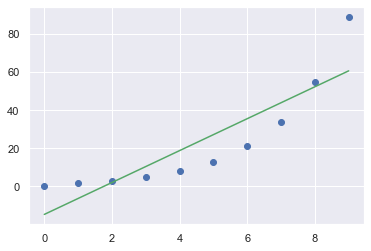

In [4]:
# Test simple lr

#creating data
x = np.array([0,1,2,3,4,5,6,7,8,9])
y = np.array([0,2,3,5,8,13,21,34,55,89])

res_r2_sim = simple_linear_reg(x,y)

In [5]:
res_r2_sim

0.7670001449905756

In [6]:
# Test multiple_linear_reg_model

#Manually create data set
y = np.array([4805,3783,2689,5683,3750,2684,1478,1685,1980,1075,2423,4253,1754,1873,3487,2954,4762,3076])
x0 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
x1 = np.array([130,123,98,178,134,100,78,100,95,78,110,130,73,87,152,128,180,124])
x2 = np.array([4,4,3,6,4,4,3,4,3,4,5,4,2,4,5,5,7,4])
x3 = np.array([1,1,0,1,1,0,0,0,0,0,1,1,0,1,1,1,1,0])
x4 = np.array([65,5,18,77,5,34,7,10,8,5,12,25,56,2,12,20,27,22])
x5 = np.array([410,307,254,570,335,280,180,250,237,180,286,351,220,217,400,356,520,330])
x6 = np.array([1,2,1,3,2,1,1,1,1,1,1,1,1,2,2,1,2,1])

#Convert to DataFrame for easy visualization
Data = pd.DataFrame(data = [x0,x1,x2,x3,x4,x5, x6],).T
Data.columns = [ 'CONSTANT','SURFACE',   'PERS', 'PAVILLON', 'AGE',      'VOL',   'SBAINS']
Data.head()



X = Data.to_numpy()




In [16]:
Data

,CONSTANT,SURFACE,PERS,PAVILLON,AGE,VOL,SBAINS
0,1,130,4,1,65,410,1
1,1,123,4,1,5,307,2
2,1,98,3,0,18,254,1
3,1,178,6,1,77,570,3
4,1,134,4,1,5,335,2
5,1,100,4,0,34,280,1
6,1,78,3,0,7,180,1
7,1,100,4,0,10,250,1
8,1,95,3,0,8,237,1
9,1,78,4,0,5,180,1


In [ ]:

model = multiple_linear_reg_model(X,y)
model.fit()
model.probabilities()

res_r2_multi,r2_adj = calc_r2(model)


In [8]:
res_r2_multi

0.9392259120038021

In [9]:
r2_adj

0.9060764094604216

In [12]:
print_results(model)

Analysis of Variance


,1. DF,2. Sum of Squares,3. Mean Square,4. F Value,5. Pr > F
Model,6,2.694978e+07,4.49163e+06,28.333,4.48302e-06
Error,11,1.743828e+06,158530,,
Corrected Total,17,2.869361e+07,,,


Model recap


,Values
Dependent Mean,3010.778
R-square,0.939
Adj R-square,0.906


Parameter Estimates


,1. Parameter Estimate,2. Standard Error,3. t Value,4. Pr > |t|,5. Tolerance,6. VIF
intercept,-226.408,1344.210,-0.168,0.869,,
SURFACE,28.290,54.305,0.521,0.613,0.00314466,318
PERS,-456.262,229.229,-1.990,0.072,0.134088,7.4578
PAVILLON,595.984,276.274,2.157,0.054,0.46732,2.13986
AGE,8.407,27.067,0.311,0.762,0.0262314,38.1223
VOL,4.521,20.086,0.225,0.826,0.0019833,504.211
SBAINS,-78.456,219.732,-0.357,0.728,0.523022,1.91197


In [17]:
# Visualize Test
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

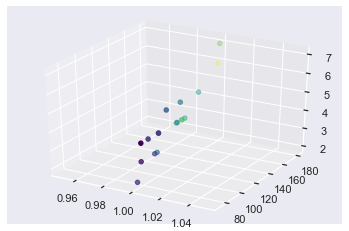

In [18]:
# https://datascience.stackexchange.com/questions/27740/plotting-multivariate-linear-regression
x0 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
x1 = np.array([130,123,98,178,134,100,78,100,95,78,110,130,73,87,152,128,180,124])
x2 = np.array([4,4,3,6,4,4,3,4,3,4,5,4,2,4,5,5,7,4])
y = np.array([4805,3783,2689,5683,3750,2684,1478,1685,1980,1075,2423,4253,1754,1873,3487,2954,4762,3076])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x0, x1, x2, c=y, cmap='viridis')
plt.show()
exit() 

In [8]:
# Read data from CSV
from pandas import read_csv
import pandas as pd
df_sub = read_csv('df_sub.csv',index_col = "time")

data_1 = read_csv('data_1.csv',index_col = "time")

In [9]:
df_sub

,V_A,V_B,V_C,W_A,W_B,W_C
time,,,,,,
1451606400000000000,117.922057,119.885924,119.516045,90.186885,85.356117,70.431450
1451607300000000000,117.908845,119.858341,119.488038,83.072034,81.717772,77.805466
1451608200000000000,117.838585,119.799965,119.413031,80.497882,80.338266,82.944247
1451609100000000000,117.770956,119.727388,119.368872,61.656277,72.531585,88.303675
1451610000000000000,117.709448,119.679749,119.290561,95.043159,57.841002,56.715511
...,...,...,...,...,...,...
1454193900000000000,118.219209,119.992793,120.051206,108.844860,50.450901,62.285578
1454194800000000000,118.166486,119.944019,119.997437,88.084557,71.172233,69.158711
1454195700000000000,118.210359,119.977326,120.030832,78.410008,81.487296,83.750088


In [6]:
data_1

,AvgPower,Voltage,ReactivePower
time,,,
1451606400000000000,71.706792,272.334904,91.050396
1451607300000000000,78.005786,271.889649,83.023792
1451608200000000000,82.481945,272.122852,80.542614
1451609100000000000,85.914474,271.132542,60.417744
1451610000000000000,56.310713,271.853249,93.462543
...,...,...,...
1454193900000000000,85.737188,274.499226,101.851904
1454194800000000000,76.489095,274.462082,90.852941
1454195700000000000,82.690515,274.321485,77.991958


In [11]:
"""
# Vn  =  k0   + k1 Vm  +  k2 Wm   + k3Wn 

Where
ki = regression coefficients
Vn = substation voltage on phase n
Wn = substation average power on phase n 
Vm = voltage at meter m
Wm = average power on meter m

"""


ind = 0
meter = data_1
ind += 1
x0 = np.ones(len(meter))
x1 = meter['Voltage']
x2 = meter['AvgPower']
for (Vn,Wn) in zip(['V_A','V_B','V_C'],['W_A','W_B','W_C']):
    x3 = df_sub[Wn]
    y = df_sub[Vn]


    print("=================================")

    Data = pd.DataFrame(data = [x0,x1,x2,x3],).T
    X = Data.to_numpy()
    model = multiple_linear_reg_model(X,y)
    model.fit()
    model.probabilities()

    r2,r2_adj = calc_r2(model)

    print ("R2:", r2,"r2_adj:", r2_adj)
    print("")

    parameter_names = ['ko','k1' ,'k2' ,'k3']
    ko,k1 ,k2 ,k3 = print_parameter_values(model,parameter_names)

R2: 0.060489026529312 r2_adj: 0.059509008128612394

Parameter Estimates


,1. Parameter Estimate,2. Standard Error,3. t Value,4. Pr > |t|,5. Tolerance,6. VIF
ko,94.677,1.763,53.693,0.000,,
k1,0.087,0.006,13.419,0.000,0.998672,1.00133
k2,-0.002,0.001,-2.416,0.016,0.8976,1.11408
k3,-0.000,0.001,-0.688,0.492,0.896682,1.11522


R2: 0.06206556200036387 r2_adj: 0.06108718810815285

Parameter Estimates


,1. Parameter Estimate,2. Standard Error,3. t Value,4. Pr > |t|,5. Tolerance,6. VIF
ko,97.349,1.683,57.847,0.000,,
k1,0.083,0.006,13.546,0.000,0.99959,1.00041
k2,-0.002,0.001,-2.655,0.008,0.932272,1.07265
k3,0.000,0.001,0.243,0.808,0.932016,1.07294


R2: 0.09649875314955242 r2_adj: 0.09555629705061246

Parameter Estimates


,1. Parameter Estimate,2. Standard Error,3. t Value,4. Pr > |t|,5. Tolerance,6. VIF
ko,92.437,1.582,58.413,0.00,,
k1,0.100,0.006,17.303,0.00,0.999956,1.00004
k2,-0.003,0.002,-1.959,0.05,0.10138,9.86392
k3,0.002,0.002,1.174,0.24,0.101381,9.86378
